#### Loading the Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings 
warnings.filterwarnings('ignore')

#### Loading the Dataset

In [2]:
# Reading the dataset and loading it to a dataframe.
def read_flight_data(file) :
    df = pd.read_excel(file,parse_dates=True)
    return df

flight_df= read_flight_data('Data_Train.xlsx')

In [3]:
# Display the first 5 records.
flight_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
#Display the info about the dataframe.
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


Number of variables: 11
Number of records: 10683
Categorical types: 10
Numerical types: 1

In [5]:
# Number of rows and columns.
flight_df.shape

(10683, 11)

In [6]:
# Some Statistical data.
flight_df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [7]:
# Count, Unique Values, Top and Frequency.

flight_df.describe(include='O').T.style.set_properties(**{'color': 'black','border-color': 'white'})

,count,unique,top,freq
Airline,10683,12,Jet Airways,3849
Date_of_Journey,10683,44,18/05/2019,504
Source,10683,5,Delhi,4537
Destination,10683,6,Cochin,4537
Route,10682,128,DEL → BOM → COK,2376
Dep_Time,10683,222,18:55,233
Arrival_Time,10683,1343,19:00,423
Duration,10683,368,2h 50m,550
Total_Stops,10682,5,1 stop,5625
Additional_Info,10683,10,No info,8345


#### Data Pre-processing and Transformations

In [8]:
# To check the count of null values.

flight_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [9]:
# Drop the rows with null values.
flight_df.dropna(inplace=True)

In [10]:
# To check for duplicates.
flight_df.duplicated().sum()

220

In [11]:
# Drop the duplicate rows.
flight_df.drop_duplicates(inplace=True)

In [12]:
# To check the count of null values after the rows are dropped.
flight_df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [13]:
# To check for duplicates after dropping them.
flight_df.duplicated().sum()

0

In [14]:
# Number of rows and columns after removing null values and duplicates.
flight_df.shape

(10462, 11)

In [15]:
def convert_time(df,col_name):
    
    # Convert duration to minutes.
    h = df[col_name].str.extract('(\d+)h', expand=False).astype(float) * 60
    m = df[col_name].str.extract('(\d+)m', expand=False).astype(float)
    df[col_name] = h.add(m, fill_value=0).astype(int).astype(str) + 'm'
    
    # Convert to integer.
    df[col_name]=df[col_name].apply(lambda x: int(x.split('m')[0]))

In [16]:
def split(x):
    x=float(x.split(':')[0])
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [17]:
# Function to pre-process the data.
def process_data(df):
    # Extract day_name and month from date_of_journey column. 
    df['Date_of_Journey']=pd.to_datetime(df.Date_of_Journey, infer_datetime_format=True)
    df['Month']=df['Date_of_Journey'].dt.month
    df['Day']=df['Date_of_Journey'].dt.day_name()

    # Convert Duration column to numerical value in minutes.
    convert_time(df,'Duration')

    # Convert Dep_time and Arrival_time to Part of day such as (evening, noon , morning ...)
    df['Dep_Time']=df['Dep_Time'].apply(split)
    df['Arrival_Time']=df['Arrival_Time'].apply(split)
    
    # Drop non benefit columns.
    df.drop(columns=['Date_of_Journey','Route'],axis=1,inplace=True)
    
    # Reindex the dataframe columns.
    df=df.reindex(columns=['Airline', 'Source', 'Destination','Month', 'Day','Dep_Time', 'Arrival_Time',
       'Duration', 'Total_Stops', 'Additional_Info', 'Price'])
    
    return df

flight_df=process_data(flight_df)

In [18]:
flight_df.replace({'No Info': 'No info'}, inplace=True)

In [19]:
# Display the first five records.
flight_df.head()

,Airline,Source,Destination,Month,Day,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,Banglore,New Delhi,3,Sunday,Night,Late Night,170,non-stop,No info,3897
1,Air India,Kolkata,Banglore,5,Wednesday,Early Morning,Noon,445,2 stops,No info,7662
2,Jet Airways,Delhi,Cochin,6,Sunday,Morning,Late Night,1140,2 stops,No info,13882
3,IndiGo,Kolkata,Banglore,5,Sunday,Evening,Night,325,1 stop,No info,6218
4,IndiGo,Banglore,New Delhi,3,Friday,Noon,Night,285,1 stop,No info,13302


#### Exploratory Data Analysis 

##### Target Variable Price Analysis

In [20]:
# To understand the statistical values of Price.
flight_df[['Price']].describe()

,Price
count,10462.000000
mean,9026.790289
std,4624.849541
min,1759.000000
25%,5224.000000
50%,8266.000000
75%,12344.750000
max,79512.000000


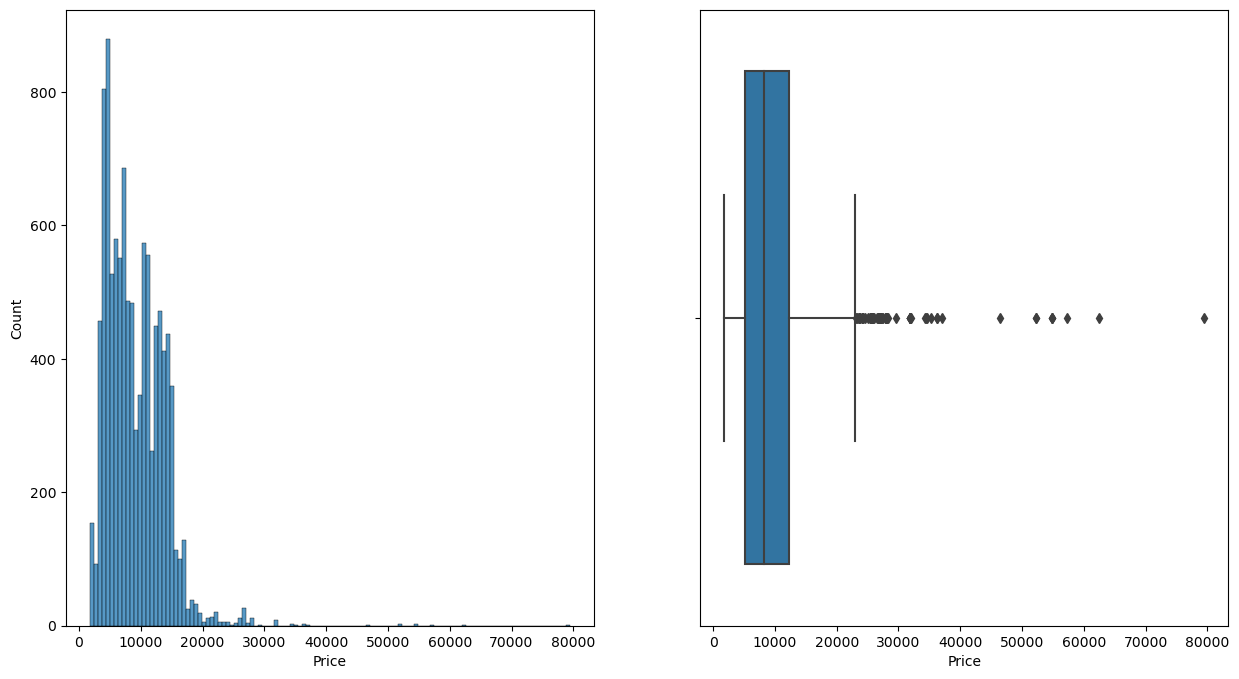

In [21]:
# A histplot and barplot of price.
fig , ax = plt.subplots(1,2,figsize=(15,8))
sns.histplot(flight_df['Price'],ax=ax[0])
sns.boxplot(data=flight_df,x='Price',ax=ax[1])
plt.show()

##### Duration 

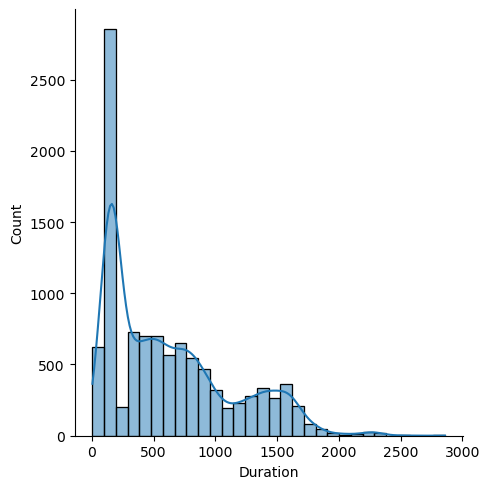

In [22]:
# A distplot of duration.
sns.displot(flight_df.Duration,bins=30,kde=True)

<AxesSubplot:>

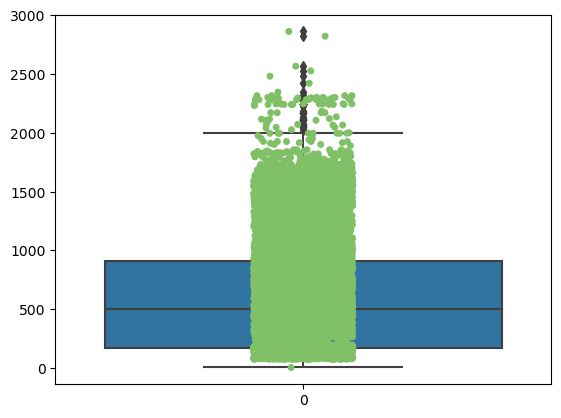

In [23]:
# A boxplot for duration.
sns.boxplot(data=flight_df.Duration)
sns.stripplot(data=flight_df.Duration,palette='summer')

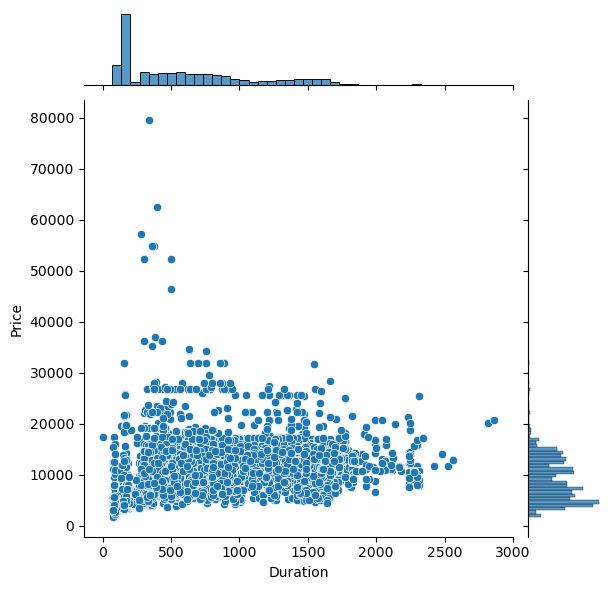

In [24]:
sns.jointplot(data=flight_df,x='Duration',y='Price',kind='scatter',palette='vridis')

Text(0.5, 1.0, 'Average prices depending on the duration')

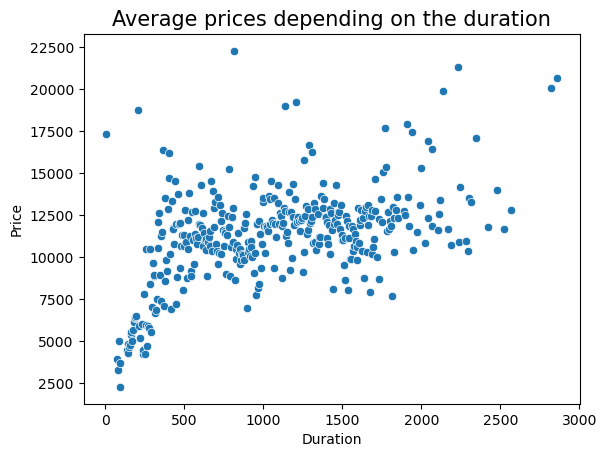

In [25]:
# Average prices depending on the duration.
Duration_df=flight_df.groupby(['Duration'])['Price'].mean().reset_index()
sns.scatterplot(data=Duration_df,x='Duration',y='Price').set_title("Average prices depending on the duration",fontsize=15)

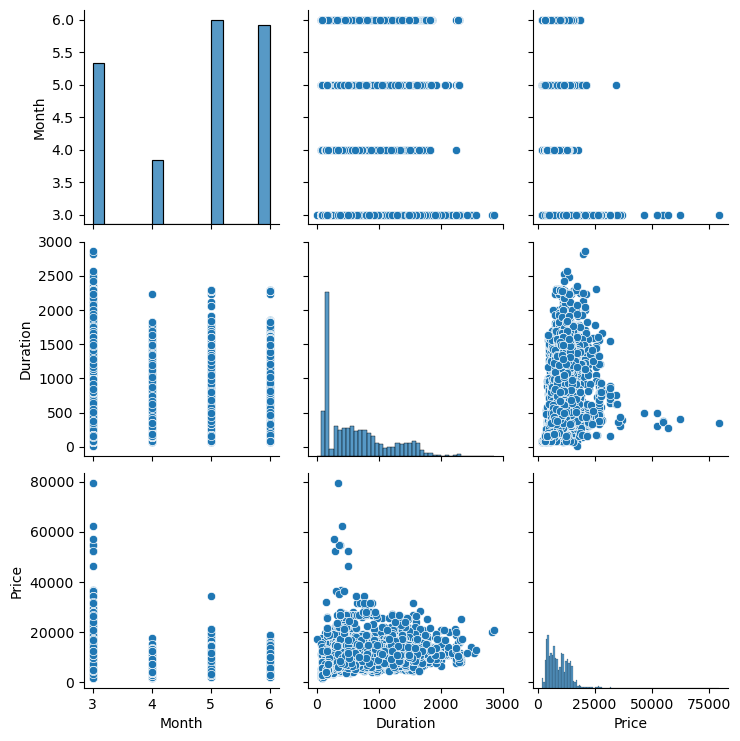

In [26]:
sns.pairplot(flight_df)

##### Airline 

<AxesSubplot:>

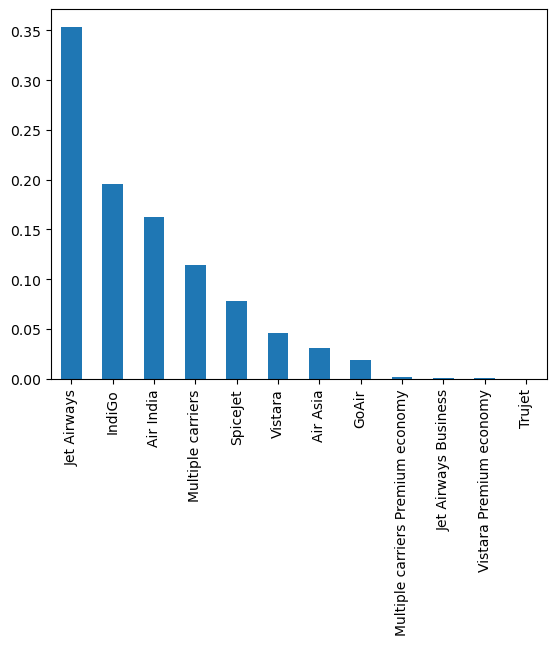

In [27]:
# To identify the top 5 airlines.
flight_df.Airline.value_counts(normalize=True).plot(kind='bar')

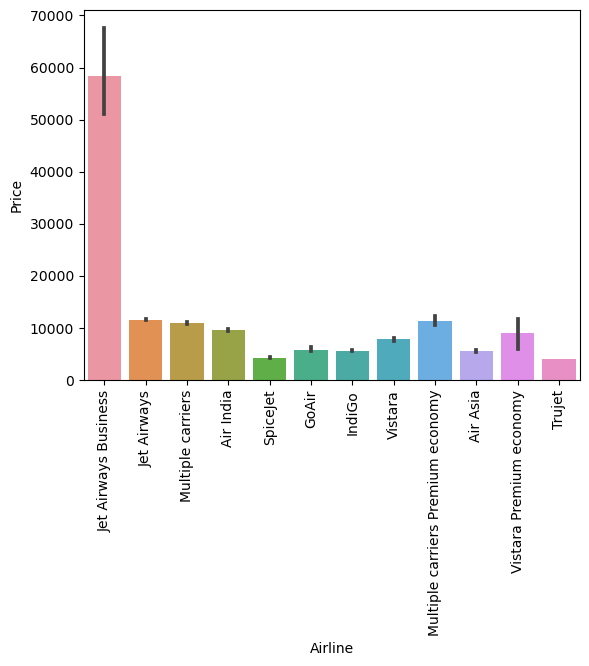

In [28]:
# Average Price of Every Airline.
sns.barplot(x='Airline',y='Price',data=flight_df.sort_values('Price',ascending=False))
plt.xticks(rotation=90)
plt.show()

##### Source and Destination 

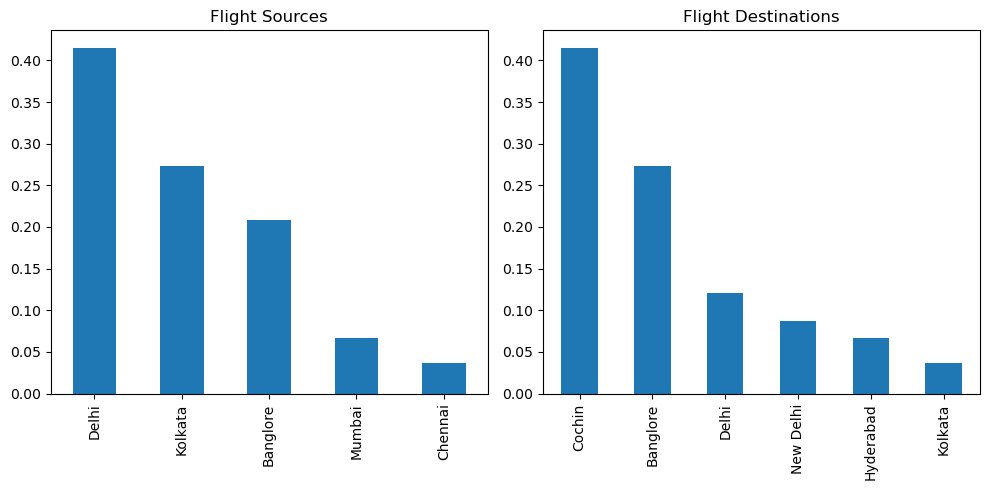

In [29]:
# To Identify top airlines for every source and destination.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

flight_df.Source.value_counts(normalize=True).plot(kind='bar', ax=ax1)
ax1.set_title('Flight Sources')

flight_df.Destination.value_counts(normalize=True).plot(kind='bar', ax=ax2)
ax2.set_title('Flight Destinations')

plt.tight_layout()
plt.show()

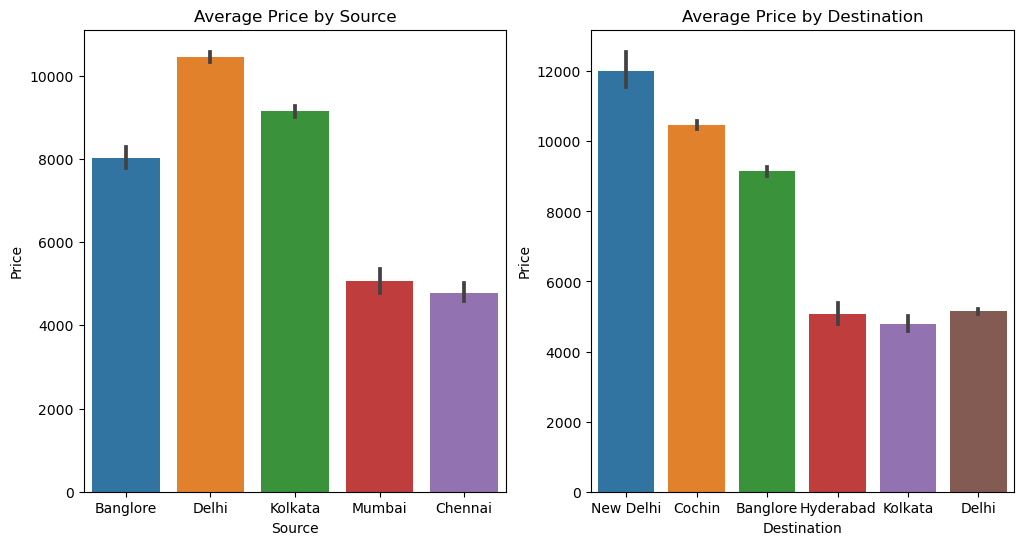

In [30]:
# Average Price for every source and destination.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.barplot(x='Source', y='Price', data=flight_df.sort_values('Price', ascending=False), ax=ax1)
ax1.set_title('Average Price by Source')

sns.barplot(x='Destination', y='Price', data=flight_df.sort_values('Price', ascending=False), ax=ax2)
ax2.set_title('Average Price by Destination')

plt.show()

##### Departure and Arrival Time 

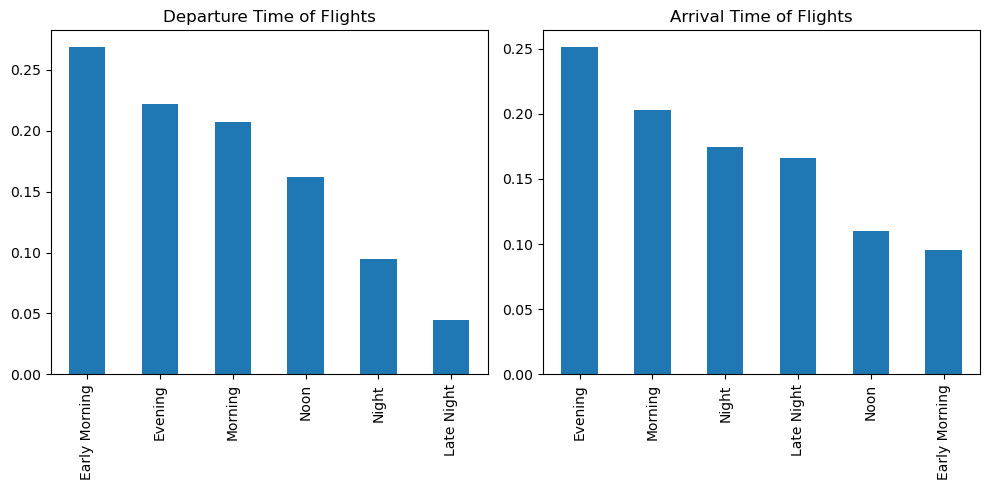

In [31]:
# Most Common Departure and Arrival Parts of Time.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

flight_df.Dep_Time.value_counts(normalize=True).plot(kind='bar', ax=ax1)
ax1.set_title('Departure Time of Flights')

flight_df.Arrival_Time.value_counts(normalize=True).plot(kind='bar', ax=ax2)
ax2.set_title('Arrival Time of Flights')

plt.tight_layout()
plt.show()

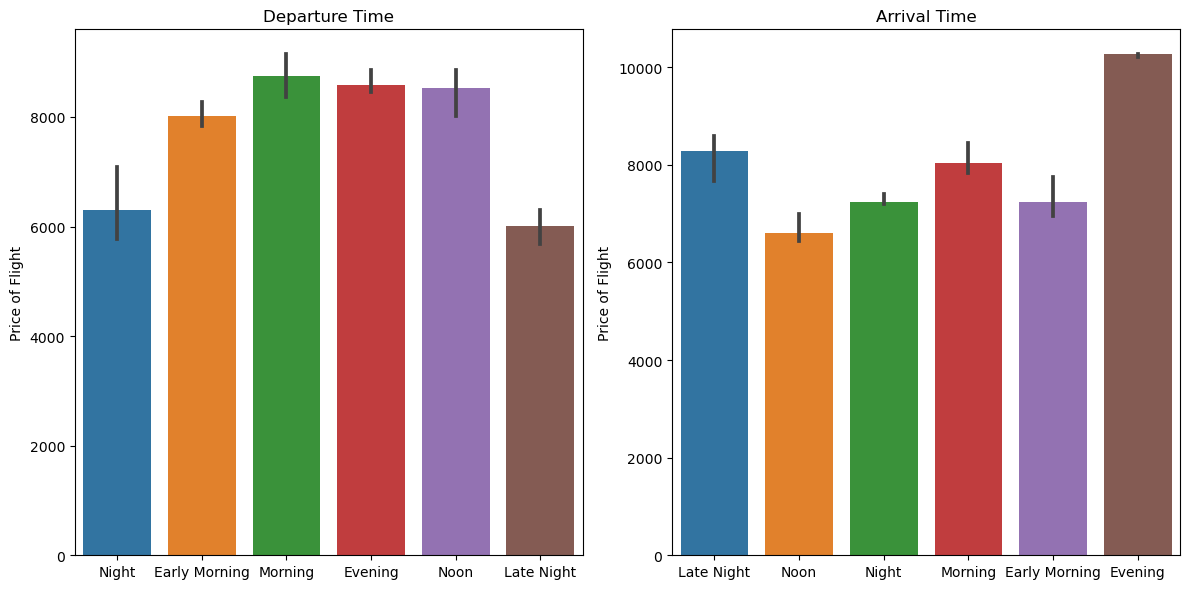

In [32]:
# Price for Different Arrival and Departure Times.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.barplot(data=flight_df, x='Dep_Time', y='Price', estimator=np.median, ax=ax1)
ax1.set_title('Departure Time')
ax1.set_ylabel('Price of Flight')
ax1.set_xlabel(None)

sns.barplot(data=flight_df, x='Arrival_Time', y='Price', estimator=np.median, ax=ax2)
ax2.set_title('Arrival Time')
ax2.set_ylabel('Price of Flight')
ax2.set_xlabel(None)

plt.tight_layout()
plt.show()

##### Total Stops 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Vistara Premium economy'),
  Text(9, 0, 'Jet Airways Business'),
  Text(10, 0, 'Multiple carriers Premium economy'),
  Text(11, 0, 'Trujet')])

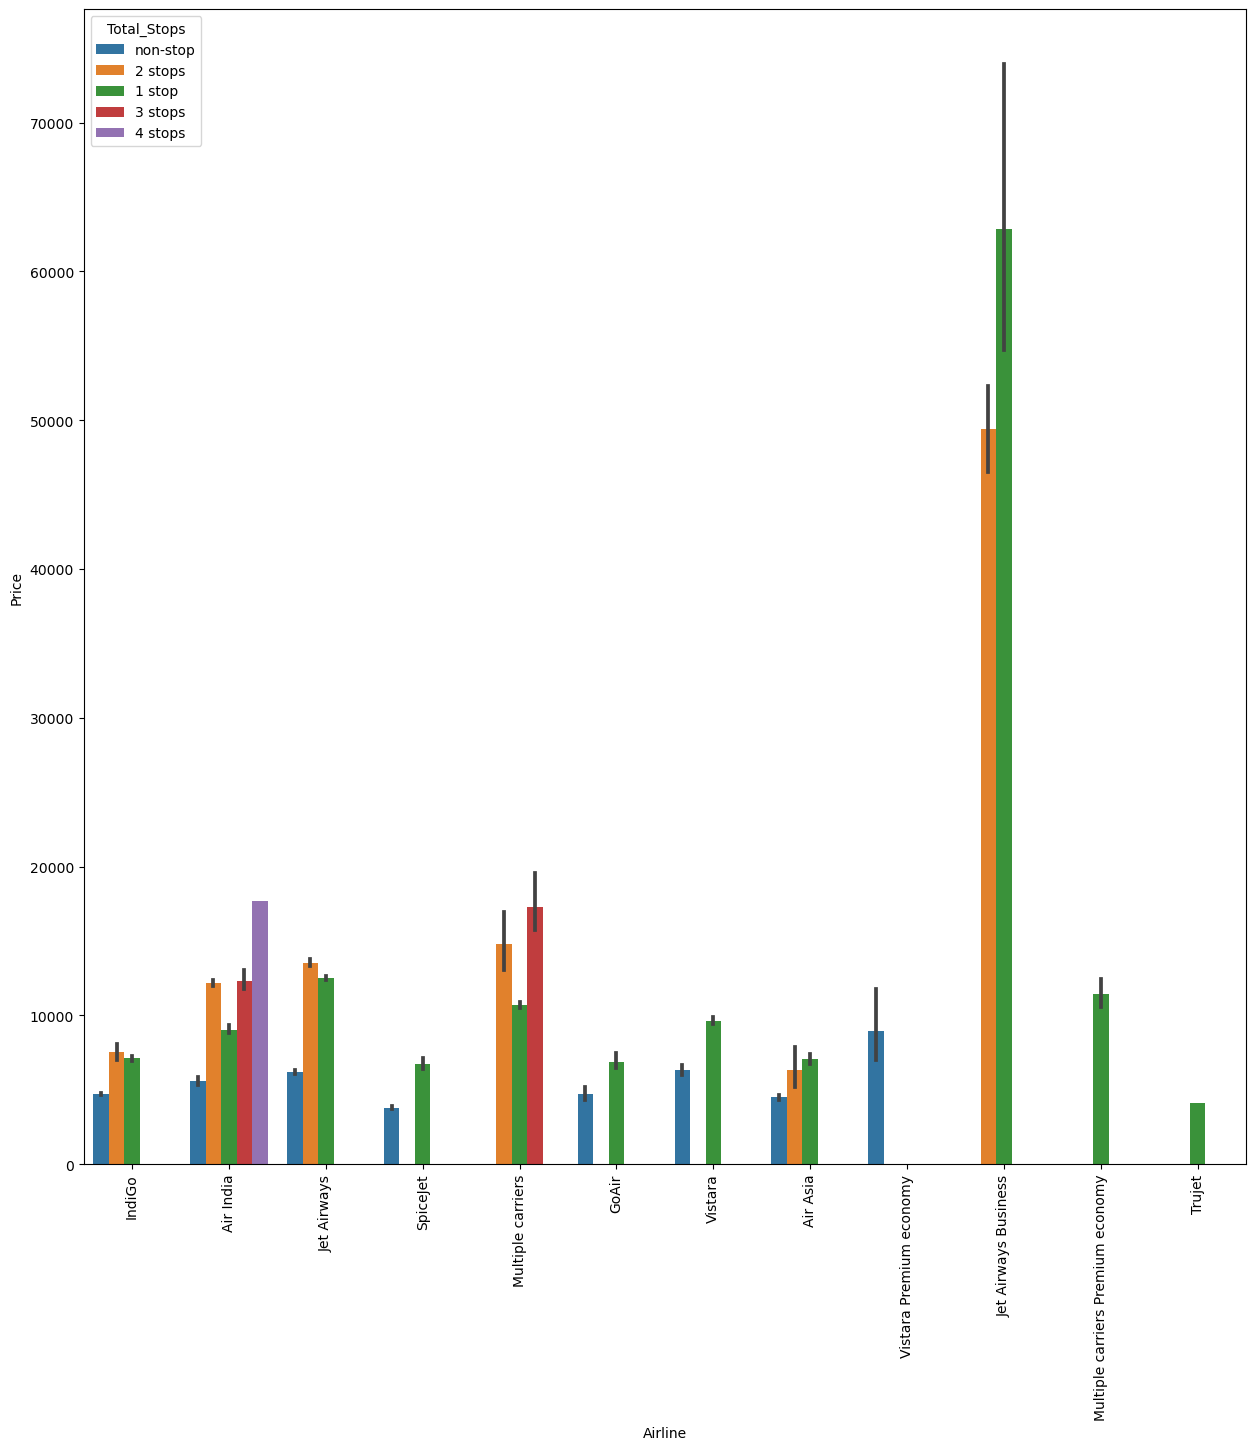

In [33]:
# Analysis of Stops.
plt.figure(figsize=(15,15))
sns.barplot(y = "Price", x = "Airline",hue="Total_Stops",data = flight_df)
plt.xticks(rotation=90)

##### Additional Info 

<AxesSubplot:>

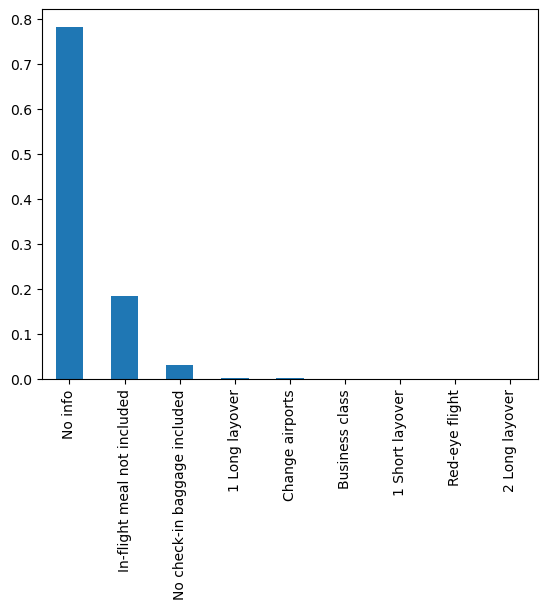

In [34]:
flight_df.Additional_Info.value_counts(normalize=True).plot(kind='bar')

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 [Text(-1.0, 0, 'Red-eye flight'),
  Text(0.0, 0, '1 Long layover'),
  Text(1.0, 0, '1 Short layover'),
  Text(2.0, 0, '2 Long layover'),
  Text(3.0, 0, 'Business class'),
  Text(4.0, 0, 'Change airports'),
  Text(5.0, 0, 'In-flight meal not included'),
  Text(6.0, 0, 'No check-in baggage included'),
  Text(7.0, 0, 'No info'),
  Text(8.0, 0, 'Red-eye flight'),
  Text(9.0, 0, '')])

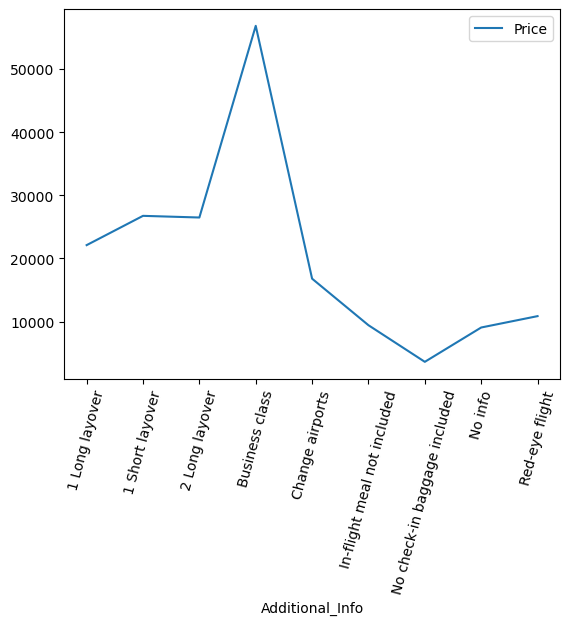

In [35]:
flight_df.groupby('Additional_Info')[['Price']].mean().plot(kind='line')
plt.xticks(rotation=75)

##### Day and Month 

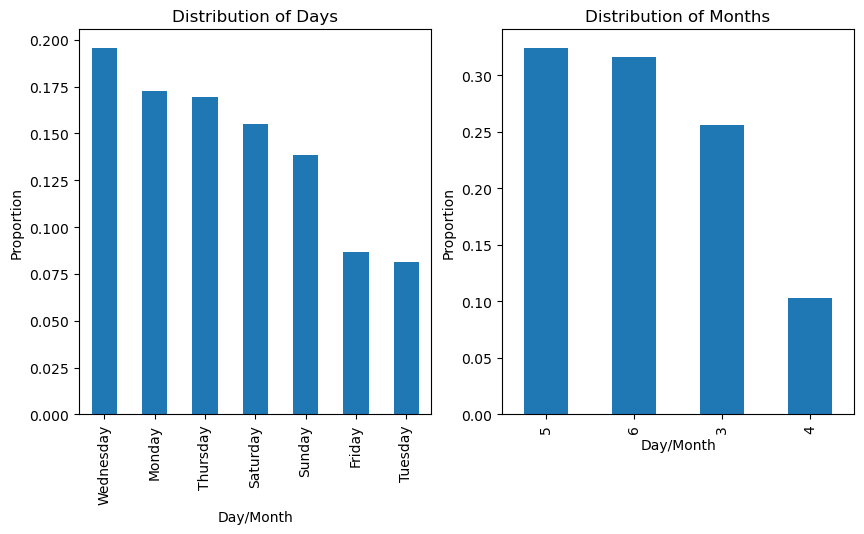

In [36]:
# Create a figure with two subplots side by side.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the distribution of days in the first subplot.
flight_df.Day.value_counts(normalize=True).plot(kind='bar', ax=axs[0])
axs[0].set_title('Distribution of Days')

# Plot the distribution of months in the second subplot.
flight_df.Month.value_counts(normalize=True).plot(kind='bar', ax=axs[1])
axs[1].set_title('Distribution of Months')

# Set the x and y labels for both subplots.
for ax in axs:
    ax.set_xlabel('Day/Month')
    ax.set_ylabel('Proportion')

# Show the plot.
plt.show()

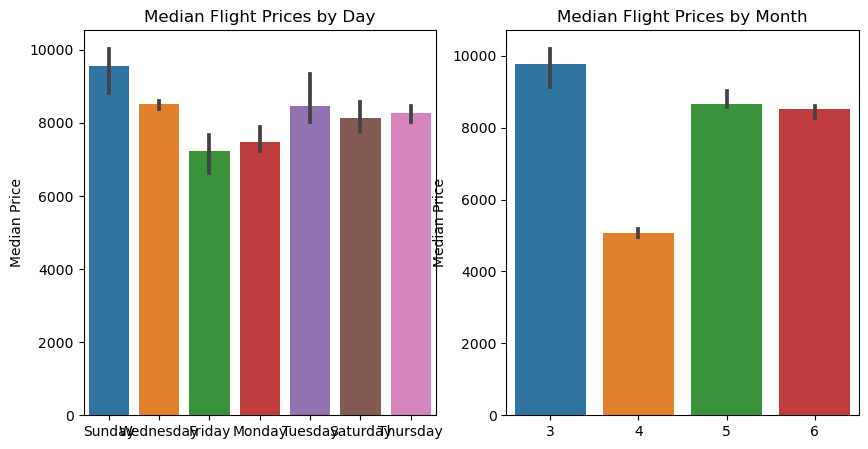

In [37]:
# Create a figure with two subplots side by side.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the median flight prices for each day in the first subplot.
sns.barplot(data=flight_df, x='Day', y='Price', estimator=np.median, ax=axs[0])
axs[0].set_title('Median Flight Prices by Day')

# Plot the median flight prices for each month in the second subplot.
sns.barplot(data=flight_df, x='Month', y='Price', estimator=np.median, ax=axs[1])
axs[1].set_title('Median Flight Prices by Month')

# Set the x and y labels for both subplots.
for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('Median Price')

# Show the plot.
plt.show()

#### Handling of Outliers 

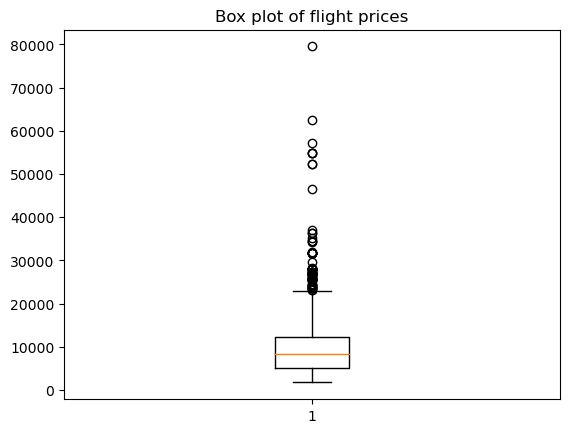

In [38]:
# Boxplot to check for outliers.
plt.boxplot(flight_df['Price'])
plt.title('Box plot of flight prices')
plt.show()

In [39]:
# Function to remove outliers.
def remove_airline_price_outliers(df):
    df_out = pd.DataFrame()
    for airline,airline_df in df.groupby('Airline'):
        for source,source_df in airline_df.groupby('Source'):
            for destination,destination_df in source_df.groupby('Destination'):
                
                m = np.mean(destination_df['Price'])
                st = np.std(destination_df['Price'])
                
                reduced_df = destination_df[(destination_df['Price'] >=(m-st)) & (destination_df['Price'] <= (m+st))]
                
                df_out = pd.concat([df_out,reduced_df],ignore_index=True)
        
    return df_out
        
flight_df = remove_airline_price_outliers(flight_df)

<AxesSubplot:>

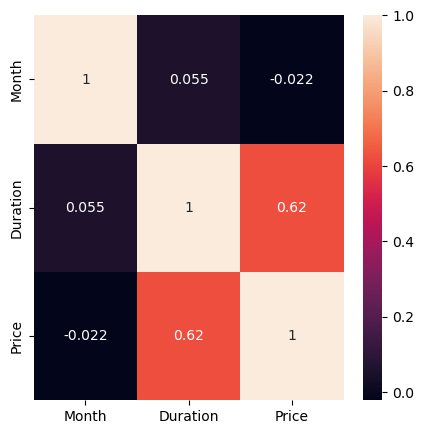

In [40]:
# Plotting heatmap with corelations to identify weakly corelated values.
plt.figure(figsize=(5,5))
sns.heatmap(flight_df.corr(),annot=True)

#### Encoding 

In [41]:
# Function to perform encoding.
def processed(df):
                
    # Label encoding
    df['Total_Stops'] = df['Total_Stops'].map({'non-stop':0 ,'1 stop':1 ,'2 stops':2,'3 stops':3,'4 stops':4})
    df['Additional_Info'] = df['Additional_Info'].map({'No info':0, 'In-flight meal not included':1,
                                                     'No check-in baggage included':2, '1 Short layover':3,
                                                     '1 Long layover':4, 'Change airports':5, 'Business class':6,
                                                     'Red-eye flight':7, '2 Long layover':8})
    
    # Replace all missing values in Total_Stops with np.nan.
    df['Total_Stops'].replace('NaN', np.nan, inplace=True)
    
    # Fill missing values in Total_Stops with 0.
    df['Total_Stops'].fillna(0, inplace=True)
    
    # One-hot encoding .
    dummies=['Airline', 'Source', 'Destination', 'Dep_Time', 'Arrival_Time','Month', 'Day']
    df=pd.get_dummies(df,columns=dummies,drop_first=True)
    
    return df

cleaned_flight_df = processed(flight_df)

In [42]:
cleaned_flight_df.describe()

,Duration,Total_Stops,Additional_Info,Price,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Arrival_Time_Noon,Month_4,Month_5,Month_6,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
count,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,...,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000,7884.000000
mean,611.271563,0.772197,0.259386,8378.382293,0.147514,0.020802,0.224378,0.323059,0.000507,0.107052,...,0.104262,0.101344,0.334094,0.349188,0.187722,0.165525,0.126966,0.174023,0.083460,0.184044
std,498.718900,0.662784,0.546059,3882.163103,0.354640,0.142729,0.417199,0.467675,0.022520,0.309199,...,0.305619,0.301803,0.471703,0.476744,0.390515,0.371677,0.332956,0.379154,0.276594,0.387544
min,75.000000,0.000000,0.000000,1759.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,170.000000,0.000000,0.000000,4823.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,480.000000,1.000000,0.000000,8018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,895.000000,1.000000,0.000000,11143.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2565.000000,3.000000,6.000000,62427.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
cleaned_flight_df.to_csv('flight_data_cleaned.csv', index=False)

#### Splitting Dataset for Training and Testing 

In [44]:
features = cleaned_flight_df.drop(columns =['Price'], axis = 1)
target = cleaned_flight_df['Price']

In [45]:
x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle = True, test_size = .30, random_state = 44)

In [46]:
print('Shape of training feature:', x_train.shape)
print('Shape of testing feature:', x_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (5518, 42)
Shape of testing feature: (2366, 42)
Shape of training label: (5518,)
Shape of training label: (2366,)


#### Standardization 

In [47]:
Scaler = StandardScaler()
Scaler.fit(x_train)

StandardScaler()

In [48]:
x_train = Scaler.transform(x_train)
x_test = Scaler.transform(x_test)

In [49]:
x_train

array([[-0.95049797, -1.17187394, -0.47170854, ..., -0.45719489,
        -0.31007452,  2.09491572],
       [ 0.10900813,  0.3507068 , -0.47170854, ..., -0.45719489,
        -0.31007452, -0.47734617],
       [ 1.39050597,  1.87328753, -0.47170854, ..., -0.45719489,
        -0.31007452, -0.47734617],
       ...,
       [-0.53678606,  0.3507068 , -0.47170854, ..., -0.45719489,
        -0.31007452, -0.47734617],
       [-0.85968316, -1.17187394,  1.4022207 , ..., -0.45719489,
        -0.31007452, -0.47734617],
       [-1.05140331, -1.17187394,  1.4022207 , ..., -0.45719489,
         3.22503123, -0.47734617]])

#### Modeling 

##### Random Forest

In [50]:
# Initialize the random forest regressor.
rf_model = RandomForestRegressor(n_estimators=100, random_state=44)

# Train the model on the preprocessed training data.
rf_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
rf_pred = rf_model.predict(x_test)

##### Model Evaluation

In [51]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, rf_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, rf_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, rf_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 2620764.31
Root Mean Squared Error: 1618.88
Mean Absolute Error: 618.94
R^2 Score: 0.85


In [52]:
# Create a dataframe to store the predictions.
rf1_results = pd.DataFrame({'Actual': y_test, 'Predicted': rf_pred})

# Save the predictions to a CSV file.
rf1_results.to_csv('rf_predictions_flight_imp1.csv', index=False)

##### Random Forest from another library: XGBoost

In [53]:
# Initialize the XGBoost regressor.
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=10,
    colsample_bytree=0.8,
    subsample=0.9,
    reg_alpha=0.1,
    reg_lambda=0.1,
    gamma=0,
    random_state=44
)

# Train the model on the preprocessed training data.
xgb_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
xgb_pred = xgb_model.predict(x_test)

##### Model Evaluation

In [54]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, xgb_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, xgb_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, xgb_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 2633729.98
Root Mean Squared Error: 1622.88
Mean Absolute Error: 618.49
R^2 Score: 0.85


In [55]:
# Create a dataframe to store the predictions.
rf2_results = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_pred})

# Save the predictions to a CSV file.
rf2_results.to_csv('rf_predictions_flight_imp2.csv', index=False)

##### Linear Regression 

In [56]:
# Initialize the linear regression model.
lr_model = LinearRegression()

# Train the model on the preprocessed training data.
lr_model.fit(x_train, y_train)

# Use the trained model to make predictions on the preprocessed testing data.
lr_pred = lr_model.predict(x_test)

##### Model Evaluation

In [57]:
# Calculate the mean squared error (MSE).
mse = mean_squared_error(y_test, lr_pred)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = mean_absolute_error(y_test, lr_pred)

# Calculate the coefficient of determination (R^2).
r2 = r2_score(y_test, lr_pred)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 2912260.21
Root Mean Squared Error: 1706.53
Mean Absolute Error: 1231.49
R^2 Score: 0.83


In [58]:
# Create a dataframe to store the predictions
lr1_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_pred})

# Save the predictions to a CSV file
lr1_results.to_csv('lr_predictions_flight_imp1.csv', index=False)

##### Linear Regression from another Library

In [59]:
# Add a column of ones to the feature matrix to represent the intercept term.
ones_column = np.ones((x_train.shape[0], 1))
X_train = np.hstack((ones_column, x_train))

# Compute the least-squares solution for the training data.
w = np.linalg.lstsq(X_train, y_train, rcond=None)[0]

# Add a column of ones to the test feature matrix to represent the intercept term.
ones_column = np.ones((x_test.shape[0], 1))
X_test = np.hstack((ones_column, x_test))

# Make predictions on the test data.
lr_pred = np.dot(X_test, w)

##### Model Evaluation

In [60]:
# Calculate the mean squared error (MSE).
mse = np.mean((y_test - lr_pred) ** 2)

# Calculate the root mean squared error (RMSE).
rmse = np.sqrt(mse)

# Calculate the mean absolute error (MAE).
mae = np.mean(np.abs(y_test - lr_pred))

# Calculate the coefficient of determination (R^2).
ss_res = np.sum((y_test - lr_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

# Print the evaluation metrics.
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 2916202.85
Root Mean Squared Error: 1707.69
Mean Absolute Error: 1231.73
R^2 Score: 0.83


In [61]:
# Create a dataframe to store the predictions.
lr2_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_pred})

# Save the predictions to a CSV file.
lr2_results.to_csv('lr_predictions_flight_imp2.csv', index=False)